# Sciensus Data Scientist Take Home - Joseph Mills

________________________
***Description:***

This work is focused on demonstrating the full lifecycle of a data project from input, processing, analysis and predictive algorithms using GP Prescription data.

Focus area choice: ***Chapter 8*** of the BNF (British National Formulary) - ***Malignant Disease and Immunosuppression.***

________
_____


***Preface for Hiring Team and Personal Reflection***

*My approach has largely focused on making appropriate decision for the task and to demonstrate a broad range of skills, as the task requires.*

*Through this work I have focused on Ch.8 of the BNF and have specifically chosen anomaly detection using Isolation Forests. This decision was made to limit and focus the EDA and modelling given the scale of the data at hand and to deliver meaningful insight whilst, most likely, being the chapter of most interest to Sciensus.*

*With my previous experience directly relating to classifiers/regression and time series I though best to focus my efforts on anomaly detection. This is in hope both for my personal development and to demonstrate my ability to tackle new-to-me domains and architecture.*

*Any questions, queries or qualms; please do not hesitate to get in-touch*

millsjoseph@live.co.uk


____
___

**Compatability statement;**

 This code runs on Google Colab under the free license.

 The below setting can be set at the top right of the screen.

 Runtime: **python3**


 Hardware Accelerator: **v2-8 TPU**

 note: developed on v6e-1
______

Created: 06/06/2025 Joseph Mills : *Import*

Modified: 07/06/2025 Joseph Mills : *Convert to Polars for more efficient data munge, Pandas for ML. External Data addition, DQ*

Modified: 08/06/2025 Joseph Mills : *Explore scan_ fun^ of polars, Rapids cuDF - descope both for now, run on sample, scale & optimise later*

Modified: 09/06/2025 Joseph Mills : *EDA, Iso-Forrest*
______

____

## 4.EDA

___

*Here EDA is focused on the key points listed in the brief and is non-exhaustive, various elements of EDA could be seen e.g. cov matrix later in the script in section 5. This placement is of practical use mainly.*


___
### Prescription volume/cost over time
___


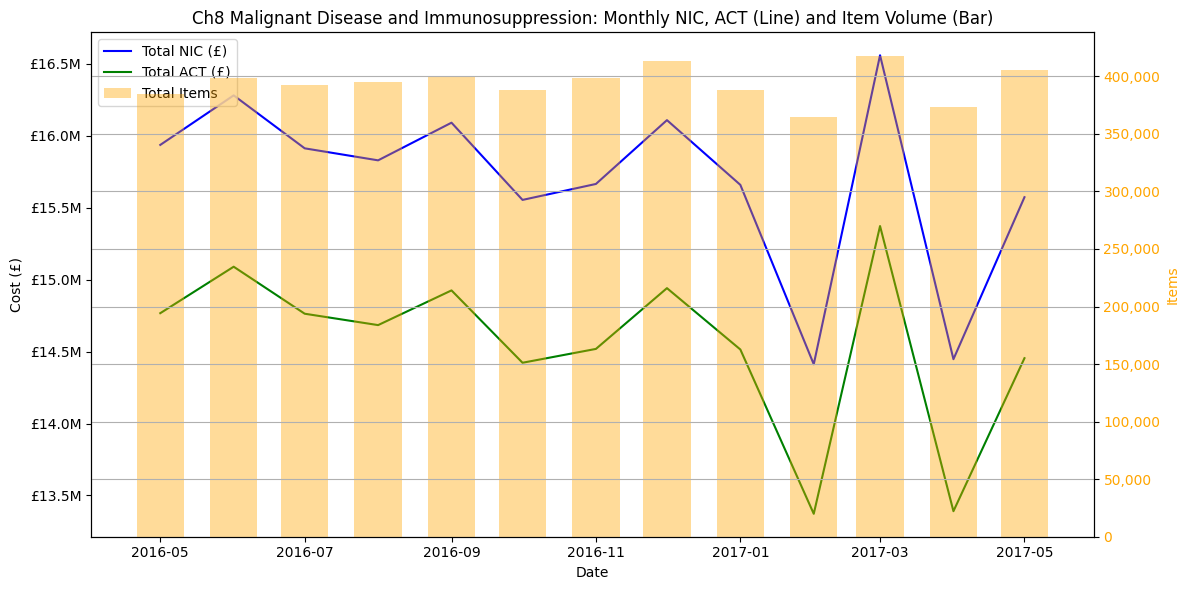

In [ ]:
## Basic Plot of total nic/act and volumes for chapter 8
from matplotlib.ticker import FuncFormatter

monthly_summary = (
    filtered_df2
    .group_by("date")
    .agg([
        pl.col("nic").sum().alias("total_NIC"),
        pl.col("act_cost").sum().alias("total_ACT"),
        pl.col("items").sum().alias("total_items")
    ])
    .sort("date")
)

# to Pd
df_plot = monthly_summary.to_pandas()
df_plot["date"] = pd.to_datetime(df_plot["date"])  # Ensure it's datetime type

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot NIC and ACT as lines on primary Y-axis
ax1.plot(df_plot["date"], df_plot["total_NIC"], label="Total NIC (£)", color="blue")
ax1.plot(df_plot["date"], df_plot["total_ACT"], label="Total ACT (£)", color="green")
ax1.set_xlabel("Date")
ax1.set_ylabel("Cost (£)", color="black")
ax1.tick_params(axis='y', labelcolor='black')

# Create a twin Y-axis for volume and plot as bars
ax2 = ax1.twinx()
ax2.bar(df_plot["date"], df_plot["total_items"], width=20, label="Total Items", color="orange", alpha=0.4)
ax2.set_ylabel("Items", color="orange")
ax2.tick_params(axis='y', labelcolor='orange')

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

# Disable scientific notation
ax1.ticklabel_format(style='plain', axis='y')
ax2.ticklabel_format(style='plain', axis='y')

# Optional: Format values
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'£{x/1e6:.1f}M'))  # Format NIC/ACT
ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))     # Format items

plt.title("Ch8 Malignant Disease and Immunosuppression: Monthly NIC, ACT (Line) and Item Volume (Bar)")
plt.grid(True)
plt.tight_layout()
plt.show()


*Evident Seasonality as expected but clear YOY between 2016-05 and 2017-05
will need to consider this in particular WRT time series..
Jan Feb and April are odd or March is odd (end of NHS FY...

This is confirmed in Open perscribing, all areas having peak in March Each FY*

In [ ]:
# Total NIC appears to be arround 10billion PA. LSE confirm 5% annual 18-21... these roughly equate to figures online
# Believe this excludes medicines dispenses in hospitals
# Malignant Disease and Immunosuppression (chapter 8) approximately matches spending on OS (OP)
## 161 Million in 24-25 (13 million in March 25) which indicates downward tragectory...


___
### National most prescribed drugs
___

In [ ]:
top_10_names = (
    filtered_df2
    .group_by("NAME")
    .agg([
        pl.col("items").sum().alias("total_items")
    ])
    .sort("total_items", descending=True)
    .limit(10)
)

print("items",top_10_names)

top_10_nic_names = (
    filtered_df2
    .group_by("NAME")
    .agg([
        pl.col("nic").sum().alias("total_nic")
    ])
    .sort("total_nic", descending=True)
    .limit(10)
)


print("act_cost",top_10_nic_names)


top_10_act_names = (
    filtered_df2
    .group_by("NAME")
    .agg([
        pl.col("act_cost").sum().alias("total_act_cost")
    ])
    .sort("total_act_cost", descending=True)
    .limit(10)
)


print("nic",top_10_act_names)




items shape: (10, 2)
┌───────────────────────┬─────────────┐
│ NAME                  ┆ total_items │
│ ---                   ┆ ---         │
│ str                   ┆ i64         │
╞═══════════════════════╪═════════════╡
│ Azathioprine          ┆ 998013      │
│ Letrozole             ┆ 827804      │
│ Tamoxifen Citrate     ┆ 793882      │
│ Anastrozole           ┆ 660437      │
│ Bicalutamide          ┆ 274267      │
│ Goserelin Acetate     ┆ 260355      │
│ Leuprorelin Acetate   ┆ 225265      │
│ Mycophenolate Mofetil ┆ 218351      │
│ Tacrolimus            ┆ 169736      │
│ Exemestane            ┆ 150655      │
└───────────────────────┴─────────────┘
act_cost shape: (10, 2)
┌───────────────────────┬────────────┐
│ NAME                  ┆ total_nic  │
│ ---                   ┆ ---        │
│ str                   ┆ f64        │
╞═══════════════════════╪════════════╡
│ Goserelin Acetate     ┆ 4.6434e7   │
│ Leuprorelin Acetate   ┆ 4.3772e7   │
│ Tacrolimus            ┆ 2.7899e7   │
│ T

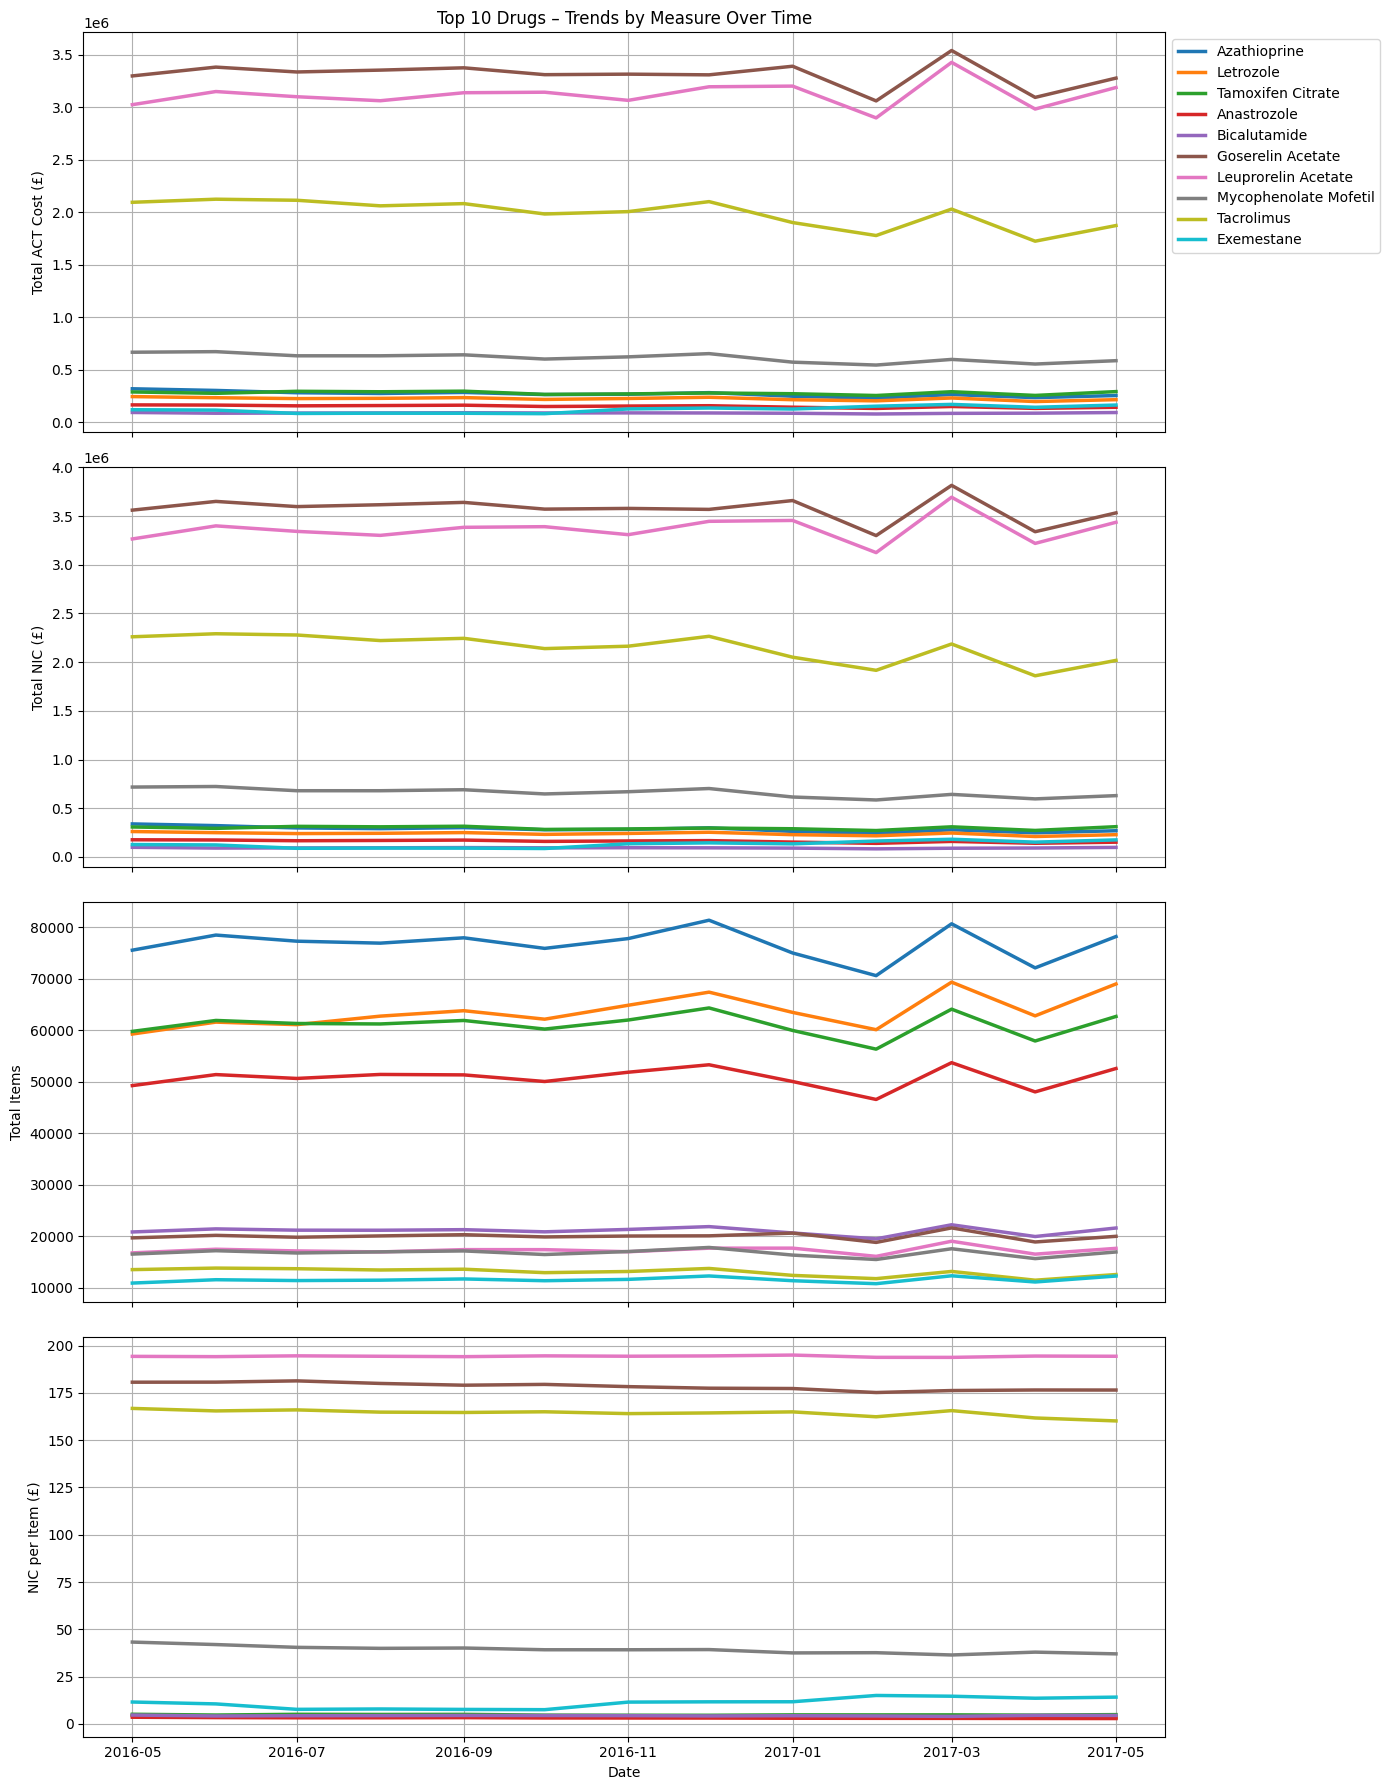

In [ ]:
### Top 10 drugs by time, for nic, act, items
grouped = (
        filtered_df2
    .group_by(["date", "NAME"])
    .agg([
        pl.col("act_cost").sum().alias("total_act_cost"),
        pl.col("nic").sum().alias("total_nic"),
        pl.col("items").sum().alias("total_items")
    ])
    .sort(["NAME", "date"])
)

# Step 3: Convert to pandas
df_plot = grouped.to_pandas()

# Step 4: Calculate nic/items
df_plot["nic_per_item"] = df_plot["total_nic"] / df_plot["total_items"]


fig, axes = plt.subplots(4, 1, figsize=(14, 18), sharex=True)

metrics = [
    ("total_act_cost", "Total ACT Cost (£)"),
    ("total_nic", "Total NIC (£)"),
    ("total_items", "Total Items"),
    ("nic_per_item", "NIC per Item (£)")
]
# Loop PLOT
for idx, (metric, label) in enumerate(metrics):
    ax = axes[idx]
    for name in top_10_names['NAME'].to_list():
        sub_df = df_plot[df_plot["NAME"] == name]
        ax.plot(sub_df["date"], sub_df[metric], label=name, linewidth=2.5)
    ax.set_ylabel(label)
    ax.grid(True)
    if idx == 0:
        ax.set_title("Top 10 Drugs – Trends by Measure Over Time")
    if idx == len(metrics) - 1:
        ax.set_xlabel("Date")

# Add legend only once
axes[0].legend(loc="upper left", bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

In [ ]:
### interesting change in use, apparently changes to perscription cost to treat the same condition
### letrozole, anastrozole and exemestane are apparently interchangeable with no one being better than the other
### many of these drugs above are used in similar circumstances and changes to price per unit may be indicative of changes in pracitice
### alternatively it highlights that this data does not indicate dosage etc. and the concentration of these medications can also not be compared
### so extrapolation alone suggests this
### this is a key consideration in later analysis
### Open Prescribing has drug alternatives.
### above may be indicative of changing brands/supplier


___
### Regional/Practise prescribing pattern variation

____

In [ ]:
## change YOY
## plot variation using folium

may_2016 = datetime.date(2016, 5, 1)
may_2017 = datetime.date(2017, 5, 1)

# Step 2: Filter the DataFrame
filtered = filtered_df2.filter(
    pl.col("date").is_in([may_2016, may_2017])
)

# Step 2: Group by practice and date, sum act_cost
grouped = (
    filtered
    .group_by(["practice_name", "date", "latitude", "longitude","Number of patients"])
    .agg(pl.col("act_cost").sum().alias("total_act_cost"))
)

# Step 3: Pivot to get 2016 and 2017 as separate columns
pivoted = grouped.pivot(
    values="total_act_cost",
    index=["practice_name", "latitude", "longitude","Number of patients"],
    columns="date"
)

# Step 4: Rename columns for clarity
pivoted = pivoted.rename({
    "2016-05-01": "act_cost_2016",
    "2017-05-01": "act_cost_2017"
})

# Step 5: Calculate the difference
result = pivoted.with_columns(
    (((pl.col("act_cost_2017") - pl.col("act_cost_2016"))/pl.col("Number of patients"))*1000).alias("act_cost_diff_per_1000")
)

# Step 6: Optional sort
result = result.sort("act_cost_diff_per_1000", descending=True)
result

<ipython-input-400-59e417300c91>:20: DeprecationWarning:

the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.



practice_name,latitude,longitude,Number of patients,act_cost_2016,act_cost_2017,act_cost_diff_per_1000
str,f64,f64,i64,f64,f64,f64
"""CAREUK OOH""",51.22835,-0.3529,null,null,2.42,null
"""EAST BERKS PRIMARY CARE OOH(WA…",51.4007,-0.7635,null,1.42,null,null
"""INTERMEDIATE CARE""",53.075062,-2.501492,null,8.4,82.2,null
"""THE AYLESBURY PARTNERSHIP""",51.470175,-0.060325,null,4897.44,null,null
"""COLNE CORNER SURGERY""",53.86204,-2.16767,null,1654.57,null,null
…,…,…,…,…,…,…
"""THE PATEL PRACTICE""",54.6515,-1.2128,3197,3822.75,242.52,-1119.871755
"""THE SURGERY""",51.495983,-0.176283,1995,2775.4,40.81,-1370.721805
"""THE GLENDALE SURGERY""",55.557521,-2.054453,2075,4399.77,1160.75,-1560.973494


#### MAP: Per 1000 Registered GP Pop


*It is clear that many practice codes (or cost centres) are co-located, no further pre-processing is done to address this at this stage.*

In [ ]:
grouped2 = (
    filtered
    .group_by(["practice_name", "latitude", "longitude","Number of patients"])
    .agg(pl.col("act_cost").sum().alias("total_act_cost"))
)
grouped_pd=grouped2.to_pandas()
grouped_pd['cost_per_1000']=(grouped_pd['total_act_cost']/grouped_pd['Number of patients'])*1000


In [ ]:


# Convert to pandas
map_df = grouped_pd[["practice_name","latitude", "longitude", "cost_per_1000"]]

# Create base map
m = folium.Map(location=[54.5, -3], zoom_start=6, tiles="CartoDB positron")

# Loop through and plot each practice
for _, row in map_df.iterrows():
    change = row["cost_per_1000"]
    #color = "red" if change > 0 else "blue"
    radius = min(15, max(2, abs(change) / 300))  # scale size

    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=radius,
        #color=color,
        fill=True,
        fill_opacity=0.4,
        popup=f"{row['practice_name']}<br>£{change:,.2f}",
        ).add_to(m)

m

*There is visibly great cost per 1000 for coastal communties - this is inline with current research, would req. further analysis*

___
#### MAP: YOY Diff per 1000 GP Pop
___

In [ ]:
#pds
map_df = result.to_pandas().dropna(subset=["latitude", "longitude", "act_cost_diff_per_1000"])

# base
m = folium.Map(location=[54.5, -3], zoom_start=6, tiles="CartoDB positron")

# Loop
for _, row in map_df.iterrows():
    change = row["act_cost_diff_per_1000"]
    color = "red" if change > 0 else "blue"
    radius = min(15, max(2, abs(change) / 50))  # scale size

    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=radius,
        color=color,
        fill=True,
        fill_opacity=0.4,
        popup=f"{row['practice_name']}<br>£{change:,.2f}",
    ).add_to(m)

m

____
____

## 5.Modelling/Predictive Analytics
____

The rationale for this focus areaa is on what I believe is for more immediate focus for Sciensus and for my own development area.

- Focus Area 1: Prescription anomally detection - although not personalised can be of use in finding DQ or alternatively GP outliers
  - Identifying perscription anomally at the earliest opportunity may prevent dangerous consequences for service users
  - May offer optimisation for drug-switch for GP Pracs
  - Adds re-assurance in contracting and in conversation with regulators (e.g. MHRA) that guardrails are in-place.

____

In [ ]:
## load_checkpoint
#output_path = "/content/drive/MyDrive/filtered_df2.parquet"
#filtered_df2.write_parquet(output_path)

#filtered_df2 = pl.read_parquet(output_path)
#filtered_df2

___

### Focus area 1: perscription anomally detection
___

In [ ]:
## given no labels - this will be unsupervised learning

____
#### Additional Pre-Processing
____

*This additional pre-processing could be integrated into the data prep section, however with isolated Forests in mind this has been left in this section as most of the processing is focused for ML only and not neccesarily on analysis that would be shared wider than technical teams.*

___
##### Liquid/Tab/Inj
___

*Evident in the early stages of this work how the quantity field (and items) could skew the outputs significantly given no specified units. This is therefore engineering a feature that will act as an indicator if the drug is in Liquid/Tablet/Injected/Other. Tab flag is passed to Iso Forest later.*

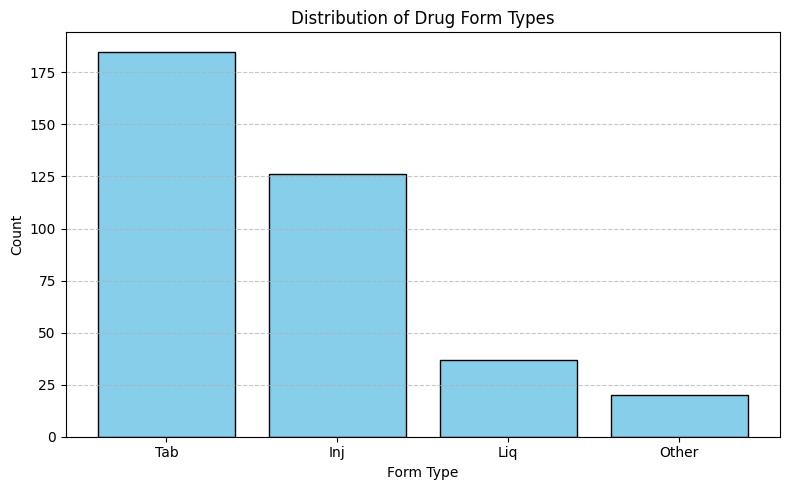

In [ ]:
### creating full drug list for parsing, so as to engineer liquid/inject/tablet/other

drugs = filtered_df2.select("bnf_name2").unique()

#  loew bnf_name to allow case-insensitive matching
drugs = drugs.with_columns(
    pl.col("bnf_name2").str.to_lowercase().alias("bnf_lower")
)


drugs = drugs.with_columns([
    pl.when(pl.col("bnf_lower").str.contains("soln"))
     .then(pl.lit("Liq"))
     .when(pl.col("bnf_lower").str.contains("susp"))
     .then(pl.lit("Liq"))
     .when(pl.col("bnf_lower").str.contains("tab"))
     .then(pl.lit("Tab"))
     .when(pl.col("bnf_lower").str.contains("cap"))
     .then(pl.lit("Tab"))
     .when(pl.col("bnf_lower").str.contains("liq"))
     .then(pl.lit("Liq"))
     .when(pl.col("bnf_lower").str.contains("inj"))
     .then(pl.lit("Inj"))
     .otherwise(pl.lit("Other"))
     .alias("form_type")
])
form_counts = drugs.to_pandas().groupby("form_type").size().reset_index(name="count").sort_values("count", ascending=False)

# Step 2: Convert to pandas for plotting
form_counts_pd = form_counts

# Step 3: Plot
plt.figure(figsize=(8, 5))
plt.bar(form_counts_pd["form_type"], form_counts_pd["count"], color="skyblue", edgecolor="black")
plt.title("Distribution of Drug Form Types")
plt.xlabel("Form Type")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
## check co-occurances...
drugs = filtered_df2.select("bnf_name2").unique().with_columns(
    pl.col("bnf_name2").str.to_lowercase().alias("bnf_lower")
)

drugs = drugs.with_columns([
    pl.col("bnf_lower").str.contains("tab|cap").alias("is_tab"),
    pl.col("bnf_lower").str.contains("soln|susp|liq").alias("is_liquid"),
    pl.col("bnf_lower").str.contains("inj").alias("is_inj"),
])

drugs = drugs.with_columns([
    (~(pl.col("is_tab") | pl.col("is_liquid") | pl.col("is_inj"))).alias("is_oth")
])

# Drop helper column
drugs = drugs.drop("bnf_lower")

df_bin = drugs.to_pandas()


binary_cols = ["is_tab", "is_liquid", "is_inj", "is_oth"]

co_matrix = pd.DataFrame(
    [[((df_bin[a]) & (df_bin[b])).sum() for b in binary_cols] for a in binary_cols],
    index=binary_cols,
    columns=binary_cols
)

print(co_matrix)

           is_tab  is_liquid  is_inj  is_oth
is_tab        186          3       3       0
is_liquid       3         39       0       0
is_inj          3          0     129       0
is_oth          0          0       0      20


In [ ]:
drugs.filter(drugs["is_tab"] & drugs["is_liquid"] )

bnf_name2,is_tab,is_liquid,is_inj,is_oth
str,bool,bool,bool,bool
"""Mercaptopurine_Liq Spec 50mg/5…",true,true,false,false
"""Mercaptopurine_Oral Susp 20mg/…",true,true,false,false
"""Mercaptopurine_Liq Spec 100mg/…",true,true,false,false


In [ ]:
#### add map back on
filtered_df2 = filtered_df2.join(
    drugs,
    on="bnf_name2",
    how="left"
)
filtered_df2[:2]

items,nic,act_cost,quantity,date,bnf_code2,bnf_name2,bnf_practice2,practice_name,region,postcode,latitude,longitude,county_name,Number of patients,bnf_chapter,bnf_section,bnf_paragraph,bnf_sub_paragraph,bnf_chemical_substance,bnf_product,bnf_strength_formulation,bnf_generic_equivalent,bnf_code_chem_sub,NAME,is_tab,is_liquid,is_inj,is_oth
i64,f64,f64,i64,date,str,str,str,str,str,str,f64,f64,str,i64,str,str,str,str,str,str,str,str,str,str,bool,bool,bool,bool
1,3.05,2.84,30,2016-05-01,"""0803041S0AAABAB""","""Tamoxifen Cit_Tab 20mg""","""N85638""","""GP APH OOH""","""WIRRAL""","""CH49 5PE""",53.3754,-3.0961,"""Merseyside""",null,"""08""","""03""","""04""","""1""","""S0""","""AA""","""AB""","""AB""","""0803041S0""","""Tamoxifen Citrate""",true,false,false,false
7,72.53,67.71,620,2016-05-01,"""0801050P0AAAAAA""","""Hydroxycarbamide_Cap 500mg""","""N81002""","""KENMORE MEDICAL CENTRE""","""CHESHIRE""","""SK9 1PA""",53.3264,-2.2281,"""Cheshire""",12562,"""08""","""01""","""05""","""0""","""P0""","""AA""","""AA""","""AA""","""0801050P0""","""Hydroxycarbamide""",true,false,false,false


____
##### Filter for Azathioprine / redundant - now for all drugs in Ch.8
____

*By means of exploring and understanding the data further, 'Azathioprine' from the parent drug classification was used initially. This has now been removed to cover all of Ch.8.*

In [ ]:
## testing with one drug (most frequent in item) Azathioprine
#azathioprine_df = filtered_df2.filter(
#    #pl.col("NAME").str.contains("Azathioprine")
#    pl.col("NAME").str.contains("Ciclosporin")##
#
#
#)
#azathioprine_df=filtered_df2
#len(azathioprine_df)

In [ ]:
#df_pandas = filtered_df2.to_pandas()
#dfSummary(df_pandas)

___
##### One Hot Encoding
____


*Here two of the BNG categories are one-hot encoded. These were not used in final model, due to explainabilty and keeping dimensionality low. This will likely be of benefit in later iterations. *

In [ ]:
## One-Hot Encoding for two select product/strength formulation potentially remove

dummies = filtered_df2.select([
    "bnf_product",
    "bnf_strength_formulation"
]).to_dummies()

# Combine with original DataFrame (optional: drop originals first)
filtered_encoded = filtered_df2.drop([
    "bnf_product",
    "bnf_strength_formulation"
]).hstack(dummies)

#filtered_encoded

___
##### Filter Population > 1000
___

*During the Modelling phase it was identified that outliers were being flagged where GP's had very few registered numbers this was a potential issue when considering the GP POP joins above.*

*If population is removed then this would not be an issue. however this would therefore mean that large GP practices/Cost Centres will subsequently be flagged,*

*Removing < 1000 should remedy this without impacting the model too much at this stage for demonstrative purposes until GP practice data is rectified.*

In [ ]:

pre=len(filtered_encoded)
filtered_encoded = filtered_encoded.filter(pl.col("Number of patients") > 1000)
post=len(filtered_encoded)
print("pre:",pre,"post",post, "diff",pre-post)

pre: 1393116 post 1369487 diff 23629


____
##### STD and population weighting
____

*To equate and incorporate as much information into a feature as possible here weighting items/nic/act_cost/quantity all with population of respective GP practice. The mean and sd are then calculated for each drug and a respective z score is created. This is then passed to the model.*

*Initially this was not completed per drug. And evidently, inappropriate outliers were identified. This was an oversite on my part, hoping this discrimination could come from one or two one_Hot encoded BNF features.*

$$
z = \frac{x - \mu}{\sigma}
$$

This by each individual drug, if no z then 0.

In [ ]:

pre = len(filtered_encoded)
filtered_encoded = filtered_encoded.filter(pl.col("Number of patients").is_not_null())
post = len(filtered_encoded)
print("pre:",pre,"post",post)


#### divid items/nic/act_cost/quantity by population number multiplied by 1000

cols_to_adjust = ["items", "nic", "act_cost", "quantity"]

# Create new per-1k
filtered_encoded = filtered_encoded.with_columns([
    ((pl.col(col) / pl.col("Number of patients") )* 1000).alias(f"{col}_per_1k")
    for col in cols_to_adjust
])

### standardizing by drug - this is in the hope to avoid any nuance with specific drugs
cols_to_standardize = [f"{col}_per_1k" for col in ["items", "nic", "act_cost", "quantity"]]

# 2. Calculate per-drug z-scores using .over("bnf_name2")
filtered_encoded = filtered_encoded.with_columns([
    pl.when(pl.col(col).std().over("bnf_name2") != 0)
      .then((pl.col(col) - pl.col(col).mean().over("bnf_name2")) / pl.col(col).std().over("bnf_name2"))
      .otherwise(0)  # Replace NaN or invalid z-scores with 0 ### very important
      .alias(f"{col}_z_by_drug")
    for col in cols_to_standardize
])

# 3. Update z_cols list
z_cols = [f"{col}_z_by_drug" for col in cols_to_standardize]

pre: 1369487 post 1369487


In [ ]:
filtered_encoded = filtered_encoded.with_columns([
    pl.when(pl.col(col).is_null() | pl.col(col).is_nan())
      .then(1)
      .otherwise(pl.col(col))
      .alias(col)
    for col in z_cols
])

In [ ]:
#one_hot_cols = [col for col in filtered_encoded.columns if col.startswith("bnf_strength_formulation_")]
#one_hot_cols2 = [col for col in filtered_encoded.columns if col.startswith("bnf_product_")]

#z_cols += one_hot_cols
#z_cols += one_hot_cols2
z_cols += ['is_tab']

In [ ]:
z_cols

['items_per_1k_z_by_drug',
 'nic_per_1k_z_by_drug',
 'act_cost_per_1k_z_by_drug',
 'quantity_per_1k_z_by_drug',
 'is_tab']

___
##### Drop NaN/null
___

*If present these are introduced in the above calculations and largely due to the limited drug data. This, in itself could be useful. i.e. rare drugs*

In [ ]:
len(filtered_encoded)

1369487

In [ ]:
filtered_encoded_pd = filtered_encoded.to_pandas()

# Drop all rows with any NaN/null
filtered_encoded_pd = filtered_encoded_pd.dropna(subset=z_cols)

filtered_encoded_pd["is_tab"] = filtered_encoded_pd["is_tab"].astype(float)


In [ ]:
del X

X = filtered_encoded_pd[z_cols]
#X = filtered_encoded_pd.select(z_cols).to_pandas()
X[:5]

,items_per_1k_z_by_drug,nic_per_1k_z_by_drug,act_cost_per_1k_z_by_drug,quantity_per_1k_z_by_drug,is_tab
0,0.876865,1.631546,1.632199,1.975839,1.0
1,-0.128871,0.158215,0.167577,-0.111867,1.0
2,-0.146262,0.226519,0.209932,-0.052013,1.0
3,-0.642878,-0.209002,-0.210480,-0.208999,1.0
4,-0.658714,-0.643233,-0.643883,-0.643230,1.0


In [ ]:
print(X.var()) # should all be vals

items_per_1k_z_by_drug       0.999706
nic_per_1k_z_by_drug         0.999717
act_cost_per_1k_z_by_drug    0.999728
quantity_per_1k_z_by_drug    0.999708
is_tab                       0.156690
dtype: float64


___
#### Covariance Matric
___

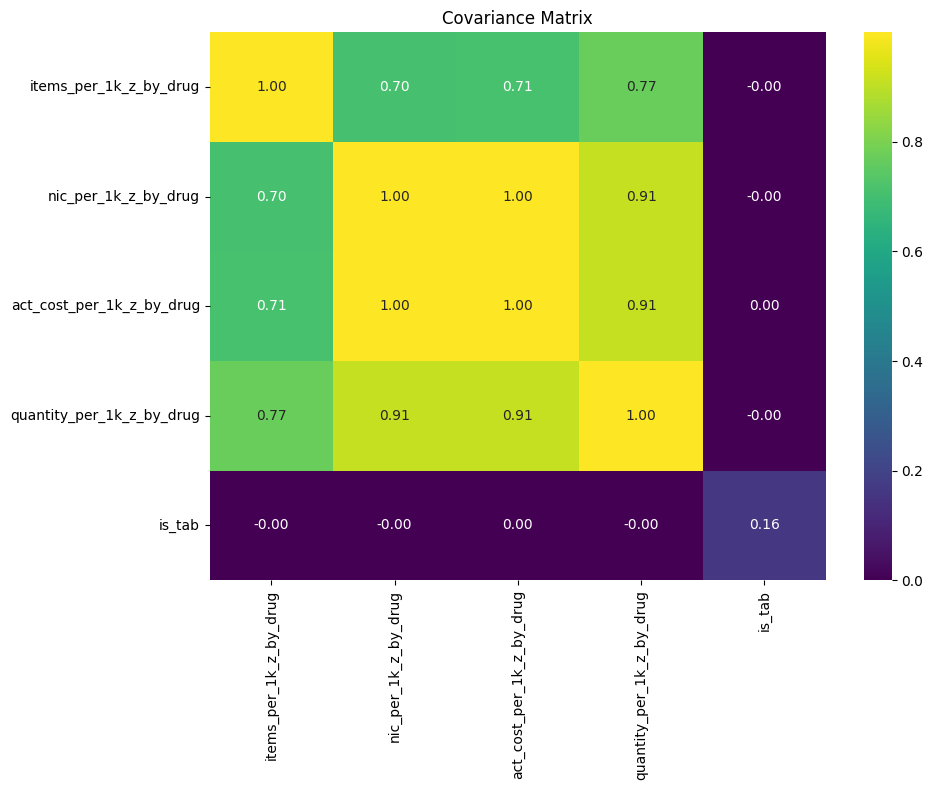

In [ ]:

cov_matrix = X.cov()
plt.figure(figsize=(10, 8))
sns.heatmap(cov_matrix, annot=True, fmt=".2f", cmap="viridis")
plt.title("Covariance Matrix")
plt.tight_layout()
plt.show()

In [ ]:
# remove nic_per_1k_z - BNF just weight transform anyway and this is evident here...
X = X.drop(columns=["nic_per_1k_z_by_drug"])

____
#### Isolation Forest
____

___
##### Train
___

In [ ]:

from sklearn.ensemble import IsolationForest
## quick run-time

#random state 42
#contamination is very low give data size, and early stages
iforest = IsolationForest(n_estimators = 100, contamination = 0.001, max_samples ='auto',random_state=42)
prediction = iforest.fit_predict(X)
print(prediction[:200])
print("Number of outliers detected: {}".format(prediction[prediction < 0].sum()))
print("Number of normal samples detected: {}".format(prediction[prediction > 0].sum()))

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Number of outliers detected: -1327
Number of normal samples detected: 1368160


___
##### Output
___

In [ ]:

filtered_encoded2 = filtered_encoded_pd
filtered_encoded2["outlier"] = prediction

In [ ]:
filtered_encoded3 = filtered_encoded2.sort_values("outlier", ascending=True)


___
##### Drug Outlier Plot - rerun if revist
____

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
#import ipywidgets as widgets
f#rom IPython.display import display

# pds
df_plot = filtered_encoded3[["act_cost_per_1k_z_by_drug"
, "items_per_1k_z_by_drug", "outlier", "NAME", "bnf_name2"]]

#  toggle
outlier_toggle = widgets.ToggleButtons(
    options=["Inliers", "Outliers", "All"],
    description="Outliers:"
)

# NAME dropdown
name_dropdown = widgets.Dropdown(
    options=["All"] + sorted(df_plot["NAME"].dropna().unique()),
    description="Drug Parent:"
)

# bnf_name2 dropdown (dependent)
bnf_dropdown = widgets.Dropdown(
    options=["All"],
    description="Drug:"
)

# Update bnf_name2 options based on NAME selection

def update_bnf_options(*args):
    selected_name = name_dropdown.value
    if selected_name == "All":
        options = sorted(df_plot["bnf_name2"].dropna().unique())
    else:
        options = sorted(df_plot[df_plot["NAME"] == selected_name]["bnf_name2"].dropna().unique())

    bnf_dropdown.options = ["All"] + options

# Attach observer to update when NAME changes
name_dropdown.observe(update_bnf_options, names='value')
update_bnf_options()  # initialize

# Plot
def plot_data(selection, selected_name, selected_bnf):
    data = df_plot.copy()

    if selected_name != "All":
        data = data[data["NAME"] == selected_name]
    if selected_bnf != "All":
        data = data[data["bnf_name2"] == selected_bnf]

    if selection == "Inliers":
        data = data[data["outlier"] == 1]
        color = "blue"
    elif selection == "Outliers":
        data = data[data["outlier"] == -1]
        color = "red"
    else:
        color = data["outlier"].map({-1: "red", 1: "blue"})

    plt.figure(figsize=(10, 6))
    plt.scatter(data["act_cost_per_1k_z_by_drug"], data["items_per_1k_z_by_drug"], c=color, alpha=0.2)
    plt.xlabel("act_cost_per_1k_z_by_drug")
    plt.ylabel("items_per_1k_z_by_drug")
    plt.title(f"{selected_name} → {selected_bnf} ({selection})")
    plt.grid(True)
    #plt.xlim(-10, 10)
    #plt.ylim(-10, 10)
    plt.tight_layout()

    if selection == "All":
        plt.legend(handles=[
            plt.Line2D([0], [0], marker='o', color='w', label='Normal', markerfacecolor='blue', markersize=8),
            plt.Line2D([0], [0], marker='o', color='w', label='Outlier', markerfacecolor='red', markersize=8)
        ])
    plt.show()

# Display interactive widget
ui = widgets.VBox([outlier_toggle, name_dropdown, bnf_dropdown])
output = widgets.interactive_output(plot_data, {
    "selection": outlier_toggle,
    "selected_name": name_dropdown,
    "selected_bnf": bnf_dropdown
})

display(ui, output)

____
##### Regional Outlier Plot
____

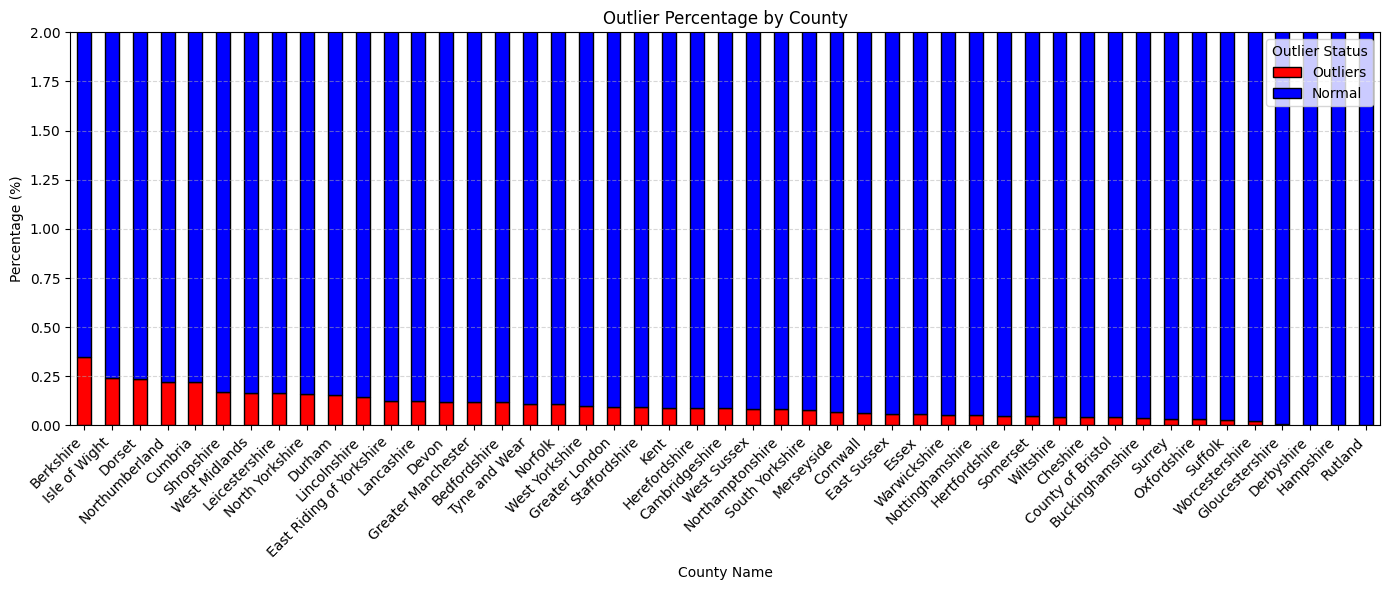

In [ ]:
df_plot = filtered_encoded3[["county_name", "outlier"]]

# SGroup by county and outlier label, count records
grouped = df_plot.groupby(["county_name", "outlier"]).size().unstack(fill_value=0)

# Rename outlier values for clarity
grouped = grouped.rename(columns={-1: "Outliers", 1: "Normal"})

#  %
grouped_percent = grouped.div(grouped.sum(axis=1), axis=0) * 100

# % sort
grouped_percent = grouped_percent.sort_values("Outliers", ascending=False)


grouped_percent.plot(
    kind="bar",
    stacked=True,
    figsize=(14, 6),
    color={"Outliers": "red", "Normal": "blue"},
    edgecolor="black"
)

plt.title("Outlier Percentage by County")
plt.xlabel("County Name")
plt.ylabel("Percentage (%)")
plt.ylim(0,2)
plt.xticks(rotation=45, ha="right")
plt.legend(title="Outlier Status")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

___
##### Temporal Outlier Plot
___

*This is particularly important to ensure that there is little change across months. Generalises well.*

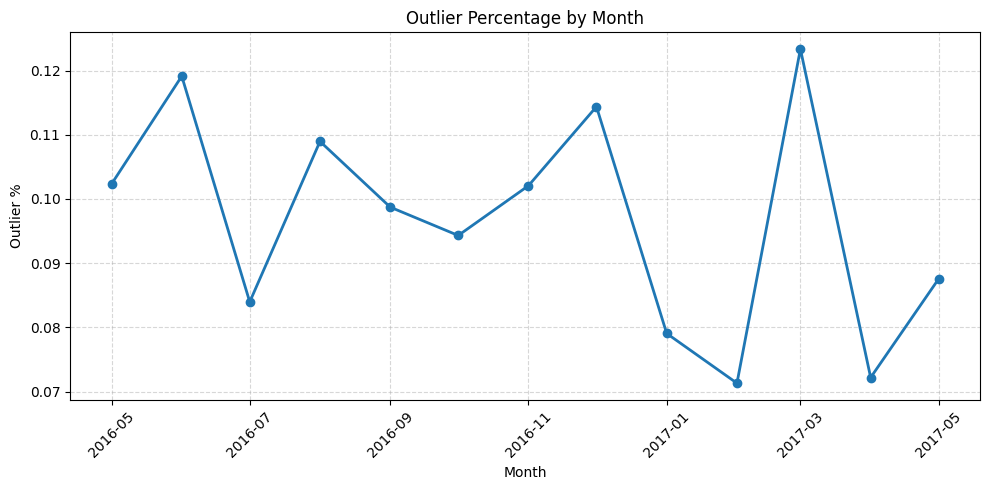

In [ ]:
monthly_outliers = (
    filtered_encoded3
    .groupby("date")
    .agg(
        total=('date', 'count'),
        outliers=('outlier', lambda x: (x == -1).sum())
    )
    .reset_index() # reset to make date


monthly_outliers["outlier_pct"] = (monthly_outliers["outliers"] / monthly_outliers["total"] * 100)
#plot
plt.figure(figsize=(10, 5))
plt.plot(monthly_outliers["date"], monthly_outliers["outlier_pct"], marker='o', linewidth=2)
plt.title("Outlier Percentage by Month")
plt.xlabel("Month")
plt.ylabel("Outlier %")
plt.grid(True, linestyle="--", alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
##reducing dimensionality and incorporating z by drug has flatted the downward tragectory somewhat, indicating generalisation

### still interesting to see this downward tragectory... suggest population changes within GP are present and need to be included regardless.
### potential shifts in main outlier signals during this time as potentially moving to other forms of medication

___
##### PCA
____

*PCA (Principle Component Analysis) is used here to visualise across input features if the outliers 'make-sense'*

In [ ]:
features = [
    "items_per_1k_z_by_drug",
    "act_cost_per_1k_z_by_drug",
    "quantity_per_1k_z_by_drug",
    "is_tab"
]

# Convert to Pandas for PCA
X = filtered_encoded3[features]
outliers = filtered_encoded3["outlier"]

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

# df for plots
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2", "PC3"])
pca_df["outlier"] = outliers

###### PLOT: Z fields

In [ ]:
import plotly.express as px
import pandas as pd

sampled_df = filtered_encoded2.sample(n=10000, random_state=42)

fig = px.scatter_3d(
    sampled_df, x="items_per_1k_z_by_drug", y="act_cost_per_1k_z_by_drug", z="quantity_per_1k_z_by_drug",
    color=sampled_df["outlier"].map({-1: "Outlier", 1: "Normal"}),
    opacity=0.5
)
fig.show()

___
###### PLOT: PCA 3
____

In [ ]:

fig = px.scatter_3d(
    pca_df[:10000], x="PC1", y="PC2", z="PC3",
    color=pca_df[:10000]["outlier"].map({-1: "Outlier", 1: "Normal"}),
    opacity=0.5
)
fig.show()

##### Model Save

____
____
## Closing Remarks
____


The work above appears to be of value in identifying trends across a 13 month period for Ch8. Analysis over multiple years, removing seasonality could prove fruitful in identifying changing population need/costs.

The anomaly model appears to accurately identify curious records when considering the form, item, quatity and price alone in relation to registered population.

By improving the GP data and enriching the data with drug alternatives. This modelling approach could prove effective in either identify incorrect/dq issues or alternatively suggesting alternative drug brand/formulation for cost saving.
